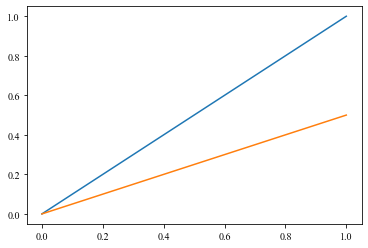

In [18]:
import matplotlib
import matplotlib.pyplot as plt


colors = matplotlib.cm.get_cmap('tab10', 10).colors
plt.plot ([0,1],[0,1], c=colors[0])
plt.plot ([0,1],[0,0.5], c=colors[1])
plt.show()




## Open-set in Imagenet Paper
This notebook contains the code to reproduce the figures and tables in the paper.

### Protocol Totals


In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator, LogLocator
import numpy as np
import pandas as pd
from robustness.tools.imagenet_helpers import ImageNetHierarchy, common_superclass_wnid
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from itertools import zip_longest
import sys
sys.path.append("../")
import src.util as util

plt.rcParams["font.family"] = "Times New Roman"

In [3]:
# read protocol data
p1_train= pd.read_csv('../data/v1/p1_train.csv', header=None, names=['path', 'label'])
p1_val= pd.read_csv('../data/v1/p1_val.csv', header=None, names=['path', 'label'])
p1_test = pd.read_csv('../data/v1/p1_test.csv', header=None, names=['path', 'label'])
p2_train= pd.read_csv('../data/v1/p2_train.csv', header=None, names=['path', 'label'])
p2_val= pd.read_csv('../data/v1/p2_val.csv', header=None, names=['path', 'label'])
p2_test = pd.read_csv('../data/v1/p2_test.csv', header=None, names=['path', 'label'])
p3_train= pd.read_csv('../data/v1/p3_train.csv', header=None, names=['path', 'label'])
p3_val= pd.read_csv('../data/v1/p3_val.csv', header=None, names=['path', 'label'])
p3_test = pd.read_csv('../data/v1/p3_test.csv', header=None, names=['path', 'label'])

def get_folder(df):
    df['folder'] = df.path.apply(lambda x: x.split('/')[1])
    return df

data = []
dfs = [p1_train, p2_train, p3_train, p1_val, p2_val, p3_val, p1_test, p2_test, p3_test, ]
protocol = ['p1_train', 'p2_train', 'p3_train', 'p1_val', 'p2_val', 'p3_val', 'p1_test', 'p2_test', 'p3_test']
for p, df in list(zip(protocol, dfs))[:]:
    df = get_folder(df)
    kn = df['label']>=0
    neg = df['label'] == -1
    unk = df['label'] == -2
    # Total Classes
    # data.append((p,df[kn].folder.nunique(), df[neg].folder.nunique(), df[unk].folder.nunique()))
    # Total Samples
    data.append((p, df[kn].path.nunique(), df[neg].path.nunique(), df[unk].path.nunique()))

df = pd.DataFrame(data, columns=['Protocol',' kn','neg','unk'])
df

,Protocol,kn,neg,unk
0,p1_train,116212,69680,0
1,p2_train,31053,29631,0
2,p3_train,156247,98775,0
3,p1_val,29061,17420,0
4,p2_val,7765,7413,0
5,p3_val,39066,24698,0
6,p1_test,5800,3350,8300
7,p2_test,1550,1500,2750
8,p3_test,7600,4850,8150


### OSCR Curves for all protocols


In [7]:
def get_models_epoch(file_dict):
    row = []
    for alias, file_path in file_dict.items():
        folder = str(file_path).split('/')[:-1]
        ckp1 = '/'.join(folder)+'/'+folder[-1]+'_best.pth'
        if alias == "$S_2$":
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_119.pth'
        else:
            ckp2 = '/'.join(folder)+'/'+folder[-1]+'_curr.pth'
        epoch1 = util.get_checkpoint_epoch(ckp1)
        epoch2 = util.get_checkpoint_epoch(ckp2)
        row.append((alias, epoch1, epoch2))
    return pd.DataFrame(row, columns =['Name', 'best', 'curr'])

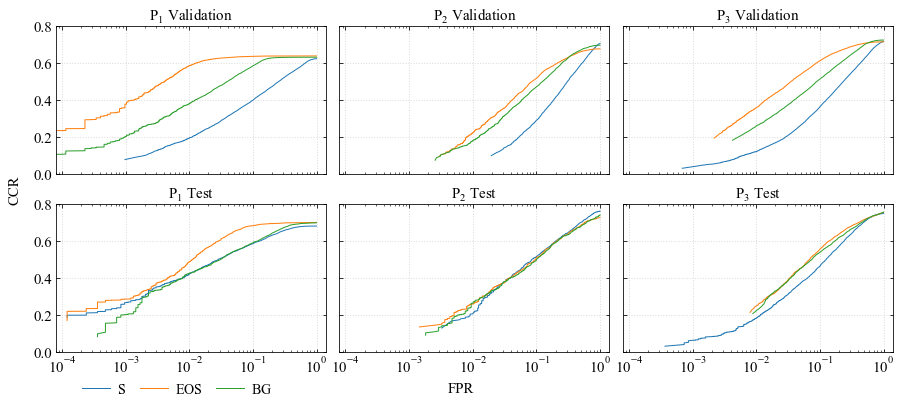

In [2]:
# General Experiments
results = Path('../../results')
outputs = Path('../outputs/')
old = Path('../outputs/old')

p1_val_paths = {
    'S_{1}':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_val_arr.npz',
    'E_{1}':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_val_arr.npz',
    'B_{1}':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_val_arr.npz',
    }
p2_val_paths = {    
    'S_{2}':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_val_arr.npz',
    'E_{2}':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_val_arr.npz',
    'B_{2}':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_val_arr.npz',
    }
p3_val_paths = {    
    'S_{3}':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_val_arr.npz',
    'E_{3}':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_val_arr.npz',    
    'B_{3}':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_val_arr.npz',
    }
p1_test_paths = {
    'S_{1}':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_test_arr.npz',
    'E_{1}':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_test_arr.npz',
    'B_{1}':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_test_arr.npz',
    }
p2_test_paths = {    
    'S_{2}':  outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_test_arr.npz',
    'E_{2}':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_test_arr.npz',
    'B_{2}':  outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_test_arr.npz',
    }
p3_test_paths = {    
    'S_{3}':  outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_test_arr.npz',
    'E_{3}':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_test_arr.npz',    
    'B_{3}':  outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_test_arr.npz',
    }

p1_val = util.read_array_list(p1_val_paths)
p2_val = util.read_array_list(p2_val_paths)
p3_val = util.read_array_list(p3_val_paths)
p1_test = util.read_array_list(p1_test_paths)
p2_test = util.read_array_list(p2_test_paths)
p3_test = util.read_array_list(p3_test_paths)

font = 15
scale = 'semilog'

fig = plt.figure(figsize=(15,6))  
gs = fig.add_gridspec(2, 3, hspace=0.2, wspace=0.05)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

ax = util.plot_oscr(arrays=p1_val, scale=scale, title='$\mathdefault{P_1}$ Validation',
                    ax_label_font=font, ax=axs[0], unk_label=-1,)
ax = util.plot_oscr(arrays=p2_val, scale=scale, title='$\mathdefault{P_2}$ Validation',
                    ax_label_font=font, ax=axs[1], unk_label=-1,)
ax = util.plot_oscr(arrays=p3_val, scale=scale, title='$\mathdefault{P_3}$ Validation',
                    ax_label_font=font, ax=axs[2], unk_label=-1,)
ax = util.plot_oscr(arrays=p1_test, scale=scale, title='$\mathdefault{P_1}$ Test',
                    ax_label_font=font, ax=axs[3], unk_label=-2,)
ax = util.plot_oscr(arrays=p2_test, scale=scale, title='$\mathdefault{P_2}$ Test',
                    ax_label_font=font, ax=axs[4], unk_label=-2,)
util.plot_oscr(arrays=p3_test, scale=scale, title='$\mathdefault{P_3}$ Test',
               ax_label_font=font, ax=axs[5], unk_label=-2,)
# Manual legend
ax.legend(['$\mathdefault{S}$', '$\mathdefault{EOS}$', '$\mathdefault{BG}$'], frameon=False,
          fontsize=font - 1, bbox_to_anchor=(-0.2, -0.12), ncol=3, handletextpad=0.5, columnspacing=1, markerscale=3)
# Axis properties
for ax in axs:
    ax.label_outer()
    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
    ax.grid(axis='y', linestyle=':', linewidth=1, color='gainsboro')
# Figure labels
fig.text(0.5, 0.03, 'FPR', ha='center', fontsize=font)
fig.text(0.08, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)
plt.savefig('fig/oscr_all_protocols_semilog.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

### Table

In [21]:
# General Experiments
outputs = Path('../outputs/')

experiments = {
    'S_{1}':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_test_arr.npz',
    'E_{1}':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_test_arr.npz',
    'B_{1}':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_test_arr.npz',
    # 's12':    outputs / 'old/s1n_l1_e0_adam_d40_g0.3_old/s1n_l1_e0_adam_d40_g0.3_best_val_arr.npz',   
    'S_{2}':    outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_test_arr.npz',
    'E_{2}':    outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_test_arr.npz',
    'B_{2}':    outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_test_arr.npz',
    # 's22':    outputs / 'old/s2_a0_w0_l1_t8_x0_e0_af_old/s2_a0_w0_l1_t8_x0_e0_af_best_val_arr.npz',   
    'S_{3}':    outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_test_arr.npz',
    'E_{3}':    outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_test_arr.npz',    
    'B_{3}':    outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_test_arr.npz',
    # 's32':    outputs / 'old/s3n_l1_e0_adam_d40_g0.3_old/s3n_l1_e0_adam_d40_g0.3_best_val_arr.npz',
   }

experiments = util.read_array_list(experiments)

def find_nearest(array, value):
    """Get the closest element in array to value"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]
    
data = []
query = [1e-3, 1e-2, 0.1,1.0]
unk_label = -2
for exp, array in experiments.items():
    target = array['gt']
    scores = array['scores']
    row = [exp] # row of data
    loss = 'BGsoftmax' if exp.startswith('B') else None
    if loss == 'BGsoftmax':
        scores = scores[:, :-1]
    ccr_, fpr_ = util.calculate_oscr(target, scores, unk_label=unk_label)

    for q in query:
        idx, fpr = find_nearest(fpr_, q)
        error = round(100*abs(fpr - q) / q, 1)
        if error >= 10.0:  # If error greater than 10% then assume fpr value not in data
            row.append('-')
        else:
            row.append(round(ccr_[idx],3))
    data.append(row)

df = pd.DataFrame(data, columns=['P', '1e-3',  '1e-2', '0.1', '1'])
df

,P,1e-3,1e-2,0.1,1
0,S_{1},0.266,0.420,0.583,0.679
1,E_{1},0.284,0.486,0.681,0.698
2,B_{1},0.201,0.424,0.589,0.696
3,S_{2},-,0.211,0.515,0.759
4,E_{2},-,0.259,0.506,0.724
5,B_{2},-,0.269,0.495,0.737
6,S_{3},0.062,0.182,0.463,0.747
7,E_{3},-,0.248,0.553,0.752
8,B_{3},-,0.225,0.538,0.754


### Confidence Metrics

In [3]:
outputs = Path('../outputs/')
event_paths = {    
    'E_{1}':  outputs / 'e1n_l1_e0_adam/events.out.tfevents.1655681577.rolf.252847.0',    
    'B_{1}':  outputs / 'b1n_l1_e0_adam/events.out.tfevents.1655681314.rolf.247397.0',
    'E_{2}':  outputs / 'e2n_l1_e0_adam/events.out.tfevents.1655681413.rolf.249030.0',
    'B_{2}':  outputs / 'b2n_l1_e0_adam/events.out.tfevents.1655681057.rolf.239916.0',
    'E_{3}':  outputs / 'e3n_l1_e0_adam/events.out.tfevents.1655711400.rolf.249245.0',
    'B_{3}':  outputs / 'b3n_l1_e0_adam/events.out.tfevents.1655681621.rolf.253932.0',}

exp_paths = {
    'S_{1}':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_test_arr.npz',
    'E_{1}':    outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_test_arr.npz',
    'B_{1}':    outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_test_arr.npz',
    # 's12':    outputs / 'old/s1n_l1_e0_adam_d40_g0.3_old/s1n_l1_e0_adam_d40_g0.3_best_val_arr.npz',   
    'S_{2}':    outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_test_arr.npz',
    'E_{2}':    outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_test_arr.npz',
    'B_{2}':    outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_test_arr.npz',
    # 's22':    outputs / 'old/s2_a0_w0_l1_t8_x0_e0_af_old/s2_a0_w0_l1_t8_x0_e0_af_best_val_arr.npz',   
    'S_{3}':    outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_test_arr.npz',
    'E_{3}':    outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_test_arr.npz',    
    'B_{3}':    outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_test_arr.npz',
    # 's32':    outputs / 'old/s3n_l1_e0_adam_d40_g0.3_old/s3n_l1_e0_adam_d40_g0.3_best_val_arr.npz',
   }

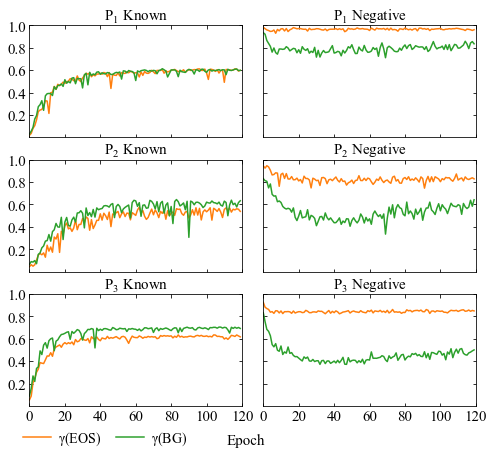

In [4]:
linewidth = 1.5
legend_pos = "lower right"
font_size = 15
color_palette = cm.get_cmap('tab10', 10).colors
fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 2, hspace=0.2, wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat

for ix, (exp_name, f_path)  in enumerate(event_paths.items()):  
    ax_kn = axs[2 * (ix//2)]
    ax_unk = axs[2 * (ix//2) + 1]
    # Read data from the tensorboard object  
    event_acc = EventAccumulator(str(f_path), size_guidance={'scalars': 0})
    event_acc.Reload()
    # Plot known confidence
    _, step_kn, val_kn = zip(*event_acc.Scalars('val/conf_kn'))
    ax_kn.plot(step_kn, val_kn, linewidth=linewidth, label = exp_name + ' kn', color=color_palette[ix%2 + 1])
    # Plot unknown confidence
    _, step_unk, val_unk = zip(*event_acc.Scalars('val/conf_unk'))
    ax_unk.plot(step_unk, val_unk, linewidth=linewidth, label = exp_name + ' unk', color=color_palette[ix%2 + 1], )
    # set titles
    title1 = "$\mathdefault{P_{" + str(ix//2 + 1) + "}}$ Known"
    title2 = "$\mathdefault{P_{" + str(ix//2 + 1) + "}}$ Negative"
    ax_kn.set_title(title1, fontsize=font_size)
    ax_unk.set_title(title2, fontsize=font_size)

# Manual legend
axs[-2].legend([ '$\mathdefault{\gamma(EOS)}$', '$\mathdefault{\gamma(BG)}$'], frameon=False,
               fontsize=font_size - 1, bbox_to_anchor=(0.8, -0.1), ncol=2, handletextpad=0.5, columnspacing=1)

for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 1)
    # Thicklocator parameters
    ax.yaxis.set_major_locator(MaxNLocator(5, prune='lower'))
    ax.xaxis.set_major_locator(MaxNLocator(6))
    ax.label_outer()
# X label
fig.text(0.5, 0.05, 'Epoch', ha='center', fontsize=font_size)
plt.savefig('fig/confidence.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

In [27]:
# Get the confidence of the correctly classified samples
threshold = 0.5
experiments = util.read_array_list(exp_paths)
data=[]
for exp_name, exp_array in experiments.items():
    gt = exp_array['gt'].astype(int)
    scores = exp_array['scores']
    
    kn = gt >= 0        # known samples
    neg = gt == -2      # negative samples
    offset = 1 / np.count_nonzero(np.unique(gt) >= 0)
    
    if exp_name.startswith("B"):   # remove last column if bg
        scores = scores[:, :-1]
        offset = 0.0
    # predictions and max scores
    pred_class = np.argmax(scores, axis=1)
    gt_score = scores[range(len(scores)), gt]
    max_score = np.max(scores, axis=1)
    
    # gets  correctly predicted samples and confidence
    correct = kn * (gt == pred_class) * ( gt_score >= threshold) 
    conf_correct = np.sum(gt_score[correct]) / sum(correct)
    # confidence of known samples
    conf_kn = np.sum(gt_score[kn]) / sum(kn)
    # confidecen fo negative samples
    conf_neg = np.sum(1 - max_score[neg]  + offset) / sum(neg)
    # average confidence
    conf = 0.5 * (conf_kn + conf_neg)
    data.append((exp_name, len(gt), sum(correct), conf_correct, conf_kn, conf_neg, conf))

df = pd.DataFrame(data, columns=['P', 'len_gt', 'len_corr', 'conf_corr', 'conf_kn', 'conf_unk', 'conf'])
df.round(3)


,P,len_gt,len_corr,conf_corr,conf_kn,conf_unk,conf
0,S_{1},17450,3875,0.957,0.666,0.520,0.593
1,E_{1},17450,3888,0.942,0.665,0.861,0.763
2,B_{1},17450,3972,0.953,0.680,0.549,0.614
3,S_{2},5800,1156,0.960,0.741,0.313,0.527
4,E_{2},5800,942,0.945,0.618,0.733,0.675
5,B_{2},5800,1050,0.959,0.679,0.496,0.587
6,S_{3},20600,5359,0.918,0.695,0.463,0.579
7,E_{3},20600,5070,0.958,0.670,0.689,0.679
8,B_{3},20600,5546,0.968,0.728,0.378,0.553


### Histograms

In [4]:
# General Experiments
outputs = Path('../outputs/')
exp_paths = {
    'S_{1}':    outputs / 's1n_l1_e0_adam/s1n_l1_e0_adam_curr_test_arr.npz',
    'EOS_{1}':  outputs / 'e1n_l1_e0_adam/e1n_l1_e0_adam_best_test_arr.npz',
    'BG_{1}':   outputs / 'b1n_l1_e0_adam/b1n_l1_e0_adam_best_test_arr.npz',
    'S_{2}':    outputs / 's2n_l1_e0_adam/s2n_l1_e0_adam_best_test_arr.npz',
    'EOS_{2}':  outputs / 'e2n_l1_e0_adam/e2n_l1_e0_adam_best_test_arr.npz',
    'BG_{2}':   outputs / 'b2n_l1_e0_adam/b2n_l1_e0_adam_best_test_arr.npz',
    'S_{3}':    outputs / 's3n_l1_e0_adam/s3n_l1_e0_adam_best_test_arr.npz',
    'EOS_{3}':  outputs / 'e3n_l1_e0_adam/e3n_l1_e0_adam_best_test_arr.npz',
    'BG_{3}':   outputs / 'b3n_l1_e0_adam/b3n_l1_e0_adam_best_test_arr.npz',}

### Softmax scores

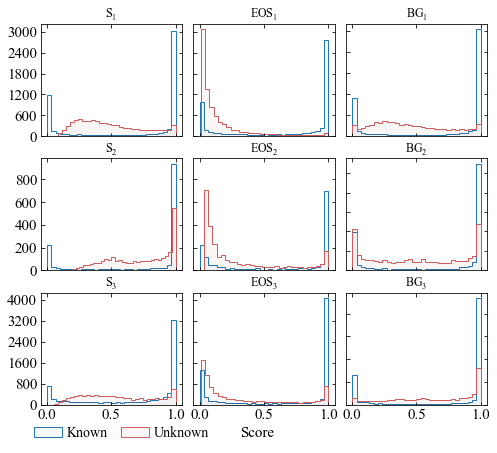

In [12]:
exp_val = util.read_array_list(exp_paths)

font_size = 15
bins = 30
unk_label = -2

fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.08)
axs = gs.subplots(sharex=True, sharey=False)
axs = axs.flat
# Manual colors
edge_unk = colors.to_rgba('indianred', 1)
fill_unk = colors.to_rgba('firebrick', 0.04)
edge_kn = colors.to_rgba('tab:blue', 1)
fill_kn = colors.to_rgba('tab:blue', 0.04)
    
for ix, (exp_name, exp_array) in enumerate(exp_val.items()):
    # Calculate histogram
    drop_bg = True if exp_name.startswith("B") else False  #  Drop the background class
    kn_hist, kn_edges, unk_hist, unk_edges = util.get_histogram(
        exp_array, 
        unk_label=unk_label, 
        metric='score', 
        bins=bins, 
        drop_bg=drop_bg
        )
    # Plot histograms
    axs[ix].stairs(kn_hist, kn_edges, fill=True, color=fill_kn, edgecolor=edge_kn, linewidth=1)
    axs[ix].stairs(unk_hist, unk_edges, fill=True, color=fill_unk, edgecolor=edge_unk, linewidth=1) 
    
    # axs[ix].set_yscale('log')
    title = "$\mathdefault{" + exp_name + "}}$"
    axs[ix].set_title(title)

# Share y axis of the histograms of the same protocol
axs[0].sharey(axs[1])
axs[3].sharey(axs[4])
axs[6].sharey(axs[7])

for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.label_outer()
    
# Manual legend
axs[-2].legend(['Known', 'Unknown'],
               frameon=False,
               fontsize=font_size-1,
               bbox_to_anchor=(0.2, -0.08),
               ncol=2,
               handletextpad=0.3,
               columnspacing=1,
               markerscale=1)
# X label
fig.text(0.5, 0.06, 'Score', ha='center', fontsize=font_size)

plt.savefig('fig/hist_all_score_lin.pdf', dpi=90, bbox_inches='tight', pad_inches = 0)
plt.show()

### Histogram Features

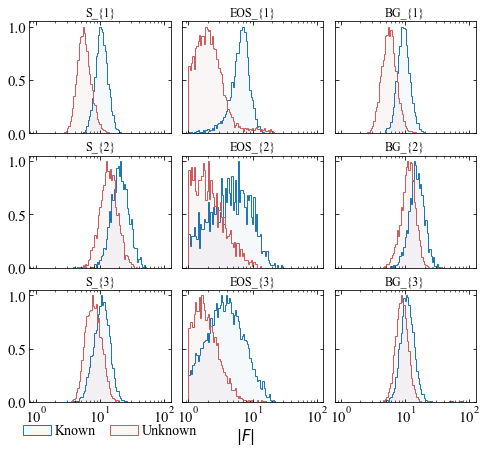

In [9]:
exp_val = util.read_array_list(exp_paths)

font_size = 15
bins = 100
unk_label = -2

fig = plt.figure(figsize=(8,7))  
gs = fig.add_gridspec(3, 3, hspace=0.2, wspace=0.08)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.flat
# Colors
edge_unk = colors.to_rgba('indianred', 1)
fill_unk = colors.to_rgba('firebrick', 0.04)
edge_kn = colors.to_rgba('tab:blue', 1)
fill_kn = colors.to_rgba('tab:blue', 0.04)
    
for ix, (exp_name, exp_array) in enumerate(exp_val.items()):
    # Calculate histogram
    kn_hist, kn_edges, unk_hist, unk_edges = util.get_histogram(exp_array, unk_label=unk_label, metric='norm', bins=bins, log_space=True)
    kn_hist = kn_hist / np.max(kn_hist)
    unk_hist = unk_hist / np.max(unk_hist)
    axs[ix].stairs(kn_hist, kn_edges, fill=True, color=fill_kn, edgecolor=edge_kn, linewidth=1)
    axs[ix].stairs(unk_hist, unk_edges, fill=True, color=fill_unk, edgecolor=edge_unk, linewidth=1)
    axs[ix].set_xscale('log')
    axs[ix].set_title(exp_name)
    
for ax in axs:
    # set the tick parameters for the current axis handler
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, labelsize=font_size)
    # Thicklocator parameters
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=6))
    ax.label_outer()
    
# Manual legend
axs[-2].legend(['Known', 'Unknown'], frameon=False, fontsize=font_size-1, bbox_to_anchor=(0.2, -0.08), ncol=2, handletextpad=0.3, columnspacing=1, markerscale=1)
# X label
fig.text(0.5, 0.05, '$|F|$', ha='center', fontsize=font_size)
plt.savefig('fig/hist_all_norm.pdf', dpi=90, bbox_inches='tight')
plt.show()

### Table of classes

In [36]:
im_info_path = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012/robustness")
root_dir = Path(r"/local/scratch/datasets/ImageNet/ILSVRC2012")
hierarchy = ImageNetHierarchy(root_dir, im_info_path)

def get_descendants_wid(hier, node_wn_id, in_imagenet=True):
        if in_imagenet:
            return sorted([ww for ww in hier.tree[node_wn_id].descendants_all
                           if ww in set(hier.in_wnids)])
        else:
            return sorted(list(hier.tree[node_wn_id].descendants_all))
        
def print_parents(tree, wnid):
    parent_id = tree[wnid].parent_wnid
    if parent_id is None:
        return 0
    print(tree[parent_id])
    print_parents(tree, parent_id)    
    
def print_descendants(hier, wid):
    des = get_descendants_wid(hier, wid, False)
    for i in des:
        print(hier.tree[i])
# fox   n02118333
# vizla n02100583
#print(hierarchy.tree['n02118333'].name.strip().split(',')[0])

In [38]:
p1_train= pd.read_csv('../data/v1/p1_train.csv', header=None, names=['path', 'label'])
p1_test = pd.read_csv('../data/v1/p1_test.csv', header=None, names=['path', 'label'])
p2_train= pd.read_csv('../data/v1/p2_train.csv', header=None, names=['path', 'label'])
p2_test = pd.read_csv('../data/v1/p2_test.csv', header=None, names=['path', 'label'])
p3_train= pd.read_csv('../data/v1/p3_train.csv', header=None, names=['path', 'label'])
p3_test = pd.read_csv('../data/v1/p3_test.csv', header=None, names=['path', 'label'])


def process_df(df):
    df['folder'] = df.path.apply(lambda x: x.split('/')[1])
    df['Name'] = df.folder.apply(lambda x: hierarchy.tree[x].name.strip().split(',')[0])
    df = df.groupby(['label', 'folder', 'Name'])['path'].count().to_frame().reset_index()
    df = df.rename({'path':'counts'}, axis=1)
    df['counts'] = df['counts'].astype(int) 
    df = df.sort_values(['folder'])
    return df

def build_table(df_train, df_test, file_path):
    df_train = process_df(df_train)
    df_test = process_df(df_test)

    kn = df_train['label'] >= 0
    neg = df_train['label'] == -1
    unk = df_test['label'] == -2

    df_train_kn = df_train[kn][['folder', 'Name',]].reset_index().rename(columns = {'index':'key', 'folder':'Id', })
    df_train_neg = df_train[neg][['folder', 'Name',]].reset_index().rename(columns = {'index':'key', 'folder':'Id', })

    df_test_unk = df_test[unk][['folder', 'Name']].reset_index().rename(columns = {'index':'key', 'folder':'Id'})
    df = pd.concat([df_train_kn, df_train_neg, df_test_unk], axis=1)
    df = df.drop(['key'], axis=1)

    df.columns = pd.MultiIndex.from_product([['Known', 'Negative', 'Unknown'],['Id', 'Name']])
    df_tex = df.to_latex(na_rep='',
                         longtable=True,
                         index=False,
                         index_names=True,
                         float_format="{:0.0f}".format,
                         caption='This is a table caption',
                         label="tab:classes",
                         column_format = '|ll|ll|ll|',
                         multicolumn_format='c'
                         )
    with open(file_path, "w") as f:
        f.write(df_tex)
        
build_table(p1_train, p1_test, "fig/p1_classes.tex")
build_table(p2_train, p2_test, "fig/p2_classes.tex")
build_table(p3_train, p3_test, "fig/p3_classes.tex")